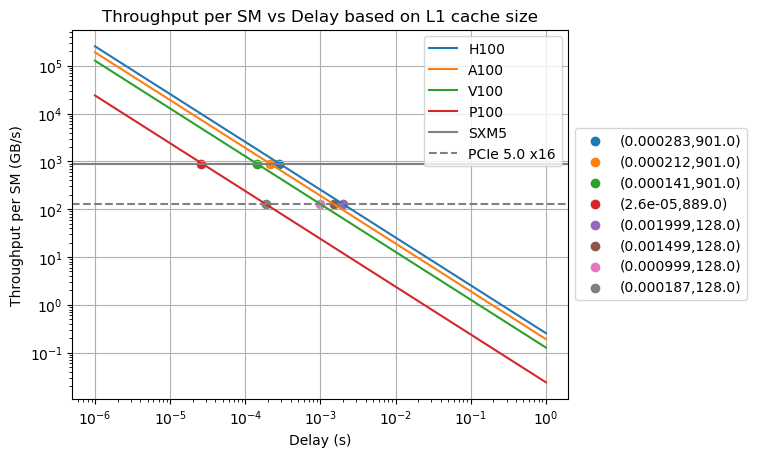

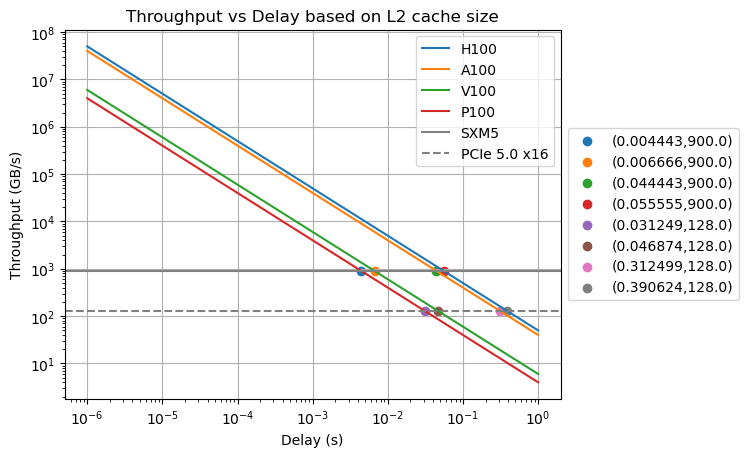

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import glob
import os


GPUs = [('H100', 256_000, 50_000_000), ('A100', 192_000, 40_000_000),('V100', 128_000, 6_000_000),('P100', 24_000, 4_000_000)]
fig_l1, ax_l1 = plt.subplots()
fig_l2, ax_l2 = plt.subplots()



# delays_ns = range(1,1000000)
delays_us = range(1, 1000000)
delays_ms = [x / 1000.0 for x in delays_us]
delays_s = [x / 1000.0 for x in delays_ms]

pcie5x16 = 128
SXM5 = 900

throughputs_l1 = []
throughputs_l2 = []
intersects_l2_pci = []
intersects_l2_sxm = []
intersects_l1_pci = []
intersects_l1_sxm = []



for name, l1, l2 in GPUs:
    throughput_l2 = []
    throughput_l1 = []
    for delay in delays_s:
        t_l2 = l2 / (delay * 1_000_000)
        t_l1 = l1 / (delay * 1_000_000)
        throughput_l2.append(t_l2)
        throughput_l1.append(t_l1)
            
    index = np.argmin(np.abs(np.array(throughput_l2)-pcie5x16))
    intersects_l2_pci.append((index/1_000_000, throughput_l2[index]))
    
    index = np.argmin(np.abs(np.array(throughput_l2)-SXM5))
    intersects_l2_sxm.append((index/1_000_000, throughput_l2[index]))
    
    index = np.argmin(np.abs(np.array(throughput_l1)-pcie5x16))
    intersects_l1_pci.append((index/1_000_000, throughput_l1[index]))
    
    index = np.argmin(np.abs(np.array(throughput_l1)-SXM5))
    intersects_l1_sxm.append((index/1_000_000, throughput_l1[index]))
    
    throughputs_l2.append((name, throughput_l2))
    throughputs_l1.append((name, throughput_l1))
    
lines_l2 = []
lines_l1 = []

for name, throughput in throughputs_l2:
    lines_l2.append(ax_l2.plot(delays_s, throughput, label=name)[0])
    
for name, throughput in throughputs_l1:
    lines_l1.append(ax_l1.plot(delays_s, throughput, label=name)[0])
    
lines_l2.append(ax_l2.axhline(y=SXM5, color='grey', label='SXM5'))
lines_l2.append(ax_l2.axhline(y=pcie5x16, color='grey', linestyle='dashed', label='PCIe 5.0 x16'))

lines_l1.append(ax_l1.axhline(y=SXM5, color='grey', label='SXM5'))
lines_l1.append(ax_l1.axhline(y=pcie5x16, color='grey', linestyle='dashed', label='PCIe 5.0 x16'))


intersects_l2_pci.sort()
intersects_l2_sxm.sort()
scatter_l2 = []
scatter_l1 = []

for delay, throughput in intersects_l2_sxm:
   scatter_l2.append(ax_l2.scatter(delay, throughput, label='(' + str(round(delay,6)) + ',' + str(round(throughput,0)) + ')'))
   
for delay, throughput in intersects_l2_pci:
   scatter_l2.append(ax_l2.scatter(delay, throughput, label='(' + str(round(delay,6)) + ',' + str(round(throughput,0)) + ')'))
   
for delay, throughput in intersects_l1_sxm:
   scatter_l1.append(ax_l1.scatter(delay, throughput, label='(' + str(round(delay,6)) + ',' + str(round(throughput,0)) + ')'))

for delay, throughput in intersects_l1_pci:
   scatter_l1.append(ax_l1.scatter(delay, throughput, label='(' + str(round(delay,6)) + ',' + str(round(throughput,0)) + ')'))


ax_l2.set_xlabel('Delay (s)')
ax_l2.set_ylabel('Throughput (GB/s)')
ax_l2.set_title('Throughput vs Delay based on L2 cache size')
ax_l2.set_xscale('log')
ax_l2.set_yscale('log')
lines_legend_l2 = ax_l2.legend(handles=lines_l2, loc='upper right')
ax_l2.legend(handles=scatter_l2, loc='center left', bbox_to_anchor=(1, 0.5))
fig_l2.gca().add_artist(lines_legend_l2)
ax_l2.grid(True)


ax_l1.set_xlabel('Delay (s)')
ax_l1.set_ylabel('Throughput per SM (GB/s)')
ax_l1.set_title('Throughput per SM vs Delay based on L1 cache size')
ax_l1.set_xscale('log')
ax_l1.set_yscale('log')
line_legend_l1 = ax_l1.legend(handles=lines_l1, loc='upper right')
ax_l1.legend(handles=scatter_l1, loc='center left', bbox_to_anchor=(1, 0.5))
fig_l1.gca().add_artist(line_legend_l1)
ax_l1.grid(True)


fig_l1.savefig('l1-throughput.svg')


fig_l2.savefig('l2-throughput.svg')

